# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

# Import data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Display df to get a sense of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


Here are the articles ids, their titles, and the e-mail addresses of all users who interacted with the article (read)

In [2]:
# Display df_content to get a sense of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


This dataframe contains more specific information about the articles' content. The column of article id can be used to join dataframes together.

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
# Duplicated rows in user-item interactions (users that read the same article many times, 
# we should not drop duplicated rows such as these because they can help later)
df.duplicated().sum()

12311

We should change the type of article id. Keeping it as float makes no sense.

In [5]:
# Change article_id type 
df.article_id = df.article_id.astype('int64')

# Drop missing rows
clean_df = df.dropna()

In [6]:
# Count the quantity of articles that each user read
user_article_int = df.groupby(['email'])['article_id'].count().reset_index(name='articles_read')

In [7]:
user_article_int['articles_read'].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: articles_read, dtype: float64

As a result, each user read 8.93 articles on average. The high standard deviation of 16.8 and the much lower median of 3 articles, on the other hand, indicate a significant number of outliers who read a large number of articles, causing the mean to rise to a high value. A histogram can be used to confirm this.

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with __3__ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is __364____.

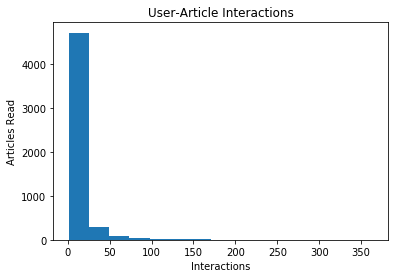

In [9]:
plt.hist(user_article_int['articles_read'], bins=15);
plt.xlabel('Interactions');
plt.ylabel('Articles Read')
plt.title('User-Article Interactions');
plt.show()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content[~df_content.duplicated(subset=['article_id'], keep='first')]

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
clean_df.article_id.nunique()

714

In [13]:
df_content.article_id.nunique()

1051

In [14]:
df.email.nunique()

5148

In [15]:
df.shape[0]

45993

In [16]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
clean_df.head()

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [18]:
aux = clean_df.groupby(['article_id','title']).count().email
aux.sort_values(ascending=False)

article_id  title                                                                             
1429        use deep learning for image classification                                            937
1330        insights from new york car accident reports                                           927
1431        visualize car data with brunel                                                        671
1427        use xgboost, scikit-learn & ibm watson machine learning apis                          643
1364        predicting churn with the spss random tree algorithm                                  627
1314        healthcare python streaming application demo                                          614
1293        finding optimal locations of new store using decision optimization                    572
1170        apache spark lab, part 1: basic concepts                                              565
1162        analyze energy consumption in buildings                                      

In [19]:
aux = aux.reset_index(level='title')

In [20]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [21]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df):
    """
    Description:
        Map the user email to ids.

    Args:
        df (dataframe): user-item interactions dataframe

    Returns:
        email_encoded (list): a list of the ids
    """
    
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper(df)
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [22]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


Let's do that cleaning again, but this time define a function to cover the entire process; this will come in handy later.

In [23]:
df = pd.read_csv('data/user-item-interactions.csv')
del df['Unnamed: 0']
del clean_df

In [24]:
def clean_data(df):
    """
    Description:
        Clean the user-item interactions dataframe.

    Args:
        df (dataframe): user-item interactions dataframe

    Returns:
        clean_df (list): user-item interactions dataframe cleaned
    """

    # Change type 
    df.article_id = df.article_id.astype('int64')
    
    # Replace e-mail with user_id
    email_encoded = email_mapper(df)
    del df['email']
    df['user_id'] = email_encoded
    
    clean_df = df
    
    return clean_df

clean_df = clean_data(df)

clean_df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [25]:
def get_top_articles(n, df=clean_df):
    """
    Description:
        Return n top articles titles ordered with most interactions as the top.

    Args:
        n (int): the number of top articles to return
        df (dataframe): user-item interactions dataframe

    Returns:
        top_articles (list): a list of the top 'n' article titles 
    """
    
    # Ranking of interactions per article 
    aux = clean_df.groupby(['article_id','title']).count().user_id
    aux = aux.sort_values(ascending=False)
    
    aux = aux.reset_index(level='title')
    
    top_articles = aux.iloc[:n,0]
    
    # Return the top article titles from user-item dataframe
    return list(top_articles)

print(get_top_articles(5, clean_df))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']


In [26]:
def get_top_article_ids(n, df=clean_df):
    """
    Description:
        Return n top articles ids ordered with most interactions as the top.

    Args:
        n (int): the number of top articles to return
        df (dataframe): user-item interactions dataframe

    Returns:
        top_articles (list): a list of the top 'n' article ids 
    """
    
    # Ranking of interactions per article 
    aux = clean_df.groupby(['article_id','title']).count().user_id
    aux = aux.sort_values(ascending=False)
    
    aux = aux.reset_index(level='article_id')
    
    top_articles = aux.iloc[:n,0]
    
    # Return the top article ids from user-item dataframe
    return list(top_articles)

print(get_top_article_ids(5, clean_df))

[1429, 1330, 1431, 1427, 1364]


In [27]:
print(get_top_articles(10, clean_df))
print(get_top_article_ids(10, clean_df))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5, clean_df)
top_10 = get_top_articles(10, clean_df)
top_20 = get_top_articles(20, clean_df)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

Let's see 

In [29]:
user_items = clean_df.copy()

# Grouping by user_id, then by article_id and count.
user_by_item = user_items.groupby(['user_id', 'article_id'])['title'].count()

user_by_item.head(50)

user_id  article_id
1        43            1
         109           1
         151           1
         268           1
         310           2
         329           1
         346           1
         390           1
         494           1
         525           1
         585           2
         626           1
         668           2
         732           1
         768           1
         910           1
         968           1
         981           1
         1052          2
         1170          2
         1183          2
         1185          2
         1232          1
         1293          1
         1305          1
         1363          2
         1368          1
         1391          1
         1400          1
         1406          2
         1427          1
         1429          1
         1430          2
         1431          2
         1436          1
         1439          1
2        1024          1
         1176          1
         1305          1
     

In [30]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df=clean_df):
    """
    Description:
        Return a matrix with user ids as rows and article ids as columns, 
        with 1 values where a user interacted with an article and 0 otherwise.

    Args:
        df (dataframe): user-item interactions dataframe

    Returns:
        user_item (dataframe): user item matrix
    """
    
    # Duplicated rows in user-item interactions 
    # We should remove duplicated rows because it makes no difference how many times a user interacts with the article. 
    # All entries in which a user has interacted with an article should be counted as only one.
    
    user_item = df.groupby(["user_id", "article_id"])["title"].max().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item 

user_item = create_user_item_matrix(clean_df)

In [31]:
# Check user-item info
user_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5149 entries, 1 to 5149
Columns: 714 entries, 0 to 1444
dtypes: int64(714)
memory usage: 28.1 MB


In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
# Visualize the user-item (user-articles) matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
def find_similar_users(user_id, user_item=user_item):
    """
    Description:
        Based on the dot product, computes the similarity of each pair of users.
    
    Args:
        user_id (int): a user_id
        user_item (dataframe): matrix of users by articles (1's when a user has interacted with an article, 0 otherwise).

    Returns:
        similar_users (list): an ordered list where the closest users (largest dot product users) are listed first
    """
               
    # Calculate each user's resemblance to the provided user.
    user_sim = {}
    
    for x in range(1, user_item.shape[0]):
        user_sim[x] = np.dot(user_item.loc[user_id], user_item.loc[x])

    # Sorting by similarity
    user_sim = sorted(user_sim.items(), key = lambda x: x[1], reverse = True)

    # Create a list that only includes the ids.
    ids = [sim[0] for sim in user_sim]
  
    # Get rid of your own user id.
    most_similar_users = [_id_ for _id_ in ids if _id_ != user_id]
        
    # Return a list of users in descending order of similarity.
    return most_similar_users
        

In [35]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [36]:
def get_article_names(article_ids, df=clean_df):
    """
    Description:
        Return the articles names you would recommend to each user.
    
    Args:
        article_ids (list): a list of article ids
        df (dataframe): df as defined at the top of the notebook

    Returns:
        article_names (list): a list of article names associated with the list of article ids
    """
    
    articles = clean_df[clean_df['article_id'].isin(article_ids)]['title'].unique()
    article_names = articles.tolist()
    
    # Return the article names that correspond to the list of article ids.
    return article_names


def get_user_articles(user_id, user_item=user_item):
    """
    Description:
        Return the articles names that a user seen.
    
    Args:
        user_id (int): a user id
        user_item (dataframe): matrix of users by articles.

    Returns:
        article_ids (list): a list of the article ids seen by the user
        article_names (list): a list of article names associated with the list of article ids 
    """
    
    n_art = len(user_item.loc[user_id])
    
    article_ids = []
    for i in range(n_art):
        if int(user_item.loc[user_id].values[i]):
            article_ids.append(str(user_item.loc[user_id].index[i]))
    

    article_names = get_article_names(article_ids)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10, df=clean_df):
    """
    Description:
        Loops through the users based on their proximity to the input user id. For each user - finds 
        articles that the user hasn't seen before and recommends them. This is repeated until m recommendations are found.
    
    Args:
        user_id (int): a user id
        m (int): the number of recommendations you want for the user

    Returns:
        recs (list): a list of recommendations for the user
        
    Notes:
    * Users who are the same closeness are chosen arbitrarily as the 'next' user.
        
    * For the user where the number of recommended articles starts below m 
      and ends exceeding m, the last items are chosen arbitrarily.
    """
    
    similar_users = find_similar_users(user_id)
    
    recs = []
    for user in similar_users:
            for article in df[df['user_id']  == user]['article_id'].tolist():
                if len(recs) < m:
                    user_seen = get_user_articles(user_id)[0]
                    if len(recs) < m & article not in user_seen:
                        recs.append(article)
                
    if len(recs) < m:
        a = numpy.random.choice(df['article_id'].values, size=1, replace=False)
        recs.append(df[df['article_id'] == a]['article_id'])
    
    # Return your recommendations for this user id.    
    return recs

In [37]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['gosales transactions for naive bayes model',
 'welcome to pixiedust',
 'uci ml repository: chronic kidney disease data set',
 'deep learning with tensorflow course by big data university',
 'rapidly build machine learning flows with dsx',
 'sudoku',
 'tidyverse practice: mapping large european cities',
 'fighting gerrymandering: using data science to draw fairer congressional districts',
 'working with ibm cloud object storage in r',
 'predict loan applicant behavior with tensorflow neural networking']

In [38]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024', '1176', '1305', '1314', '1422', '1427'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320', '232', '844'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320', '232', '844'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024', '1176', '1305', '1314', '1422', '1427'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [39]:
def get_top_sorted_users(user_id, df=clean_df, user_item=user_item):
    """
    Description:
        Sort the neighbors_df by the similarity and then by number of interactions where 
        highest of each is higher in the dataframe.
    
    Args:
        user_id (int): a user id
        df (dataframe): df as defined at the top of the notebook
        user_item (dataframe): matrix of users by articles
        
    Returns:
        neighbors_df (dataframe): a dataframe with neighbor_id - is a neighbor user_id;
                                                   similarity - measure of the similarity of each user to the provided user_id;
                                                   num_interactions - the number of articles viewed by the user - if a u.
    """
    
    # using `user_item` will count all interactions as one interaction so we are using `df`
    df_article_views  = df.user_id.value_counts() 
    
    #get number of interactions for each user
    df_article_views = df_article_views.to_frame('num_interactions')
    
    # Computing similarity
    similarity = user_item.dot(user_item.loc[user_id])
    similarity = similarity.sort_values(ascending=False)
    similarity = similarity.drop(user_id).to_frame(name='similarity')
    similarity = similarity.reset_index()
    
    # dataframe with users sorted by closest followed by most articles viewed
    neighbors_df = similarity.merge(df_article_views , left_on='user_id', right_index=True)
    neighbors_df = neighbors_df.rename(columns={'user_id':'neighbor_id'})
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    # Return the dataframe specified in the doc_string
    return neighbors_df


def user_user_recs_part2(user_id, m=10, df=clean_df):
    """
    Description:
        Loops through the users based on their proximity to the input user id. For each user - finds 
        articles that the user hasn't seen before and recommends them. This is repeated until m recommendations are found.
    
    Args:
        user_id (int): a user id
        m (int): the number of recommendations you want for the user

    Returns:
        recs (list): a list of recommendations for the user
        rec_names (list): a list of recommendations for the user by article title
        
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    """
    
    similar_users = get_top_sorted_users(user_id)['neighbor_id']
    
    recs = []
    for user in similar_users:
            for article in df[df['user_id'] == user]['article_id'].tolist():
                if len(recs) < m:
                    user_seen = get_user_articles(user_id)[0]
                    if len(recs) < m & article not in user_seen:
                        recs.append(article)
                
    if len(recs) < m:
        diff = m - len(recs)
        add_list = get_top_articles(diff, clean_df)
        recs.append(add_list)
        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [40]:
user_user_recs_part2(10)

([1305, 1314, 1422, 585, 1336, 939, 1423, 173, 1423, 379],
 ['healthcare python streaming application demo',
  '10 must attend data science, ml and ai conferences in 2018',
  'gosales transactions for naive bayes model',
  'use sql with data in hadoop python',
  'use r dataframes & ibm watson natural language understanding',
  'deep learning from scratch i: computational graphs',
  'learn basics about notebooks and apache spark',
  'data structures related to machine learning algorithms',
  'tidyverse practice: mapping large european cities'])

In [41]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1162, 1162, 1400, 232, 1368, 1368, 1437, 313, 1338, 667]
The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'analyze energy consumption in buildings', 'putting a human face on machine learning', 'uci ml repository: chronic kidney disease data set', 'imitation learning in tensorflow (hopper from openai gym)', 'self-service data preparation with ibm data refinery', 'what caused the challenger disaster?', 'what is machine learning?']


In [42]:
get_top_sorted_users(1)['neighbor_id'].head(2).values[0]

3933

In [43]:
get_top_sorted_users(131)['neighbor_id'].head(10).values[-1]

242

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [44]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [45]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer: We cannot use the user-user based collaborative filtering method, which finds similar users based on their interactions with articles, because we do not have any information about the new user's interactions with articles. Instead, we could make recommendations using the rank-based recommendation method. We can, for example, recommend the most popular articles (the most interacted articles in our case). When confronted with this type of issue, known as the cold start problem, we could also employ a content-based recommendations method, which provides recommendations based on information about the content of articles. Perhaps we can combine the output recommendations of these two methods, or create a rank-based recommendation that is separated by content. This approach has the potential to improve the relevance of the articles recommended to users.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [46]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id_) for id_ in get_top_article_ids(10)] # Your recommendations here

new_user_recs


['1429',
 '1330',
 '1431',
 '1427',
 '1364',
 '1314',
 '1293',
 '1170',
 '1162',
 '1304']

In [47]:
assert set(new_user_recs) == set(['1314','1429','1293','1427','1162','1364','1304','1170','1431','1330']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

def lemmatize(x):
    """
    Description:
        Lemmatize the titles words. 
    
    Args:
        x (string): string to tokezine.
            
    Returns:
        filtered (list): list of lemmatized words
    """
    
    # get stop words
    stop_words = set(stopwords.words('english'))
    
    # split each article title into individual words
    tokens = word_tokenize(x) 
    lemmatizer = WordNetLemmatizer()
    clean_tokens=[]
    
    for token in tokens:
        #clean each token from whitespace and punctuation, and conver to root word
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    filtered = [word for word in clean_tokens if word not in stop_words and word.isalpha()]
    return filtered


def make_content_recs(data_id, user_id=True, m=10, df=clean_df):
    """
    Description:
        This recommender goes through each article title and nltk library to finds the most common words
        (related to content) throughout all the articles. The recommender will look at the sums of words 
        in the title of each article and based on the number of matches and popularity of an article.
       
    Args:
        data_id (str) - id of either user or article
        user_id (bool) - if true, make recs based on user
        m (int) - number of recommendations to give based on term
        
    Returns:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended   
    """
    
    if(user_id):
        user_id = data_id
        try:
            # get past articles read by the user
            article_ids, articles_names = get_user_articles(user_id)
        except KeyError: # user does not exist
            print('User Doesn\'t Exist, Recommending Top Articles: \n')
            recs = get_top_article_ids(m)
            return recs, get_article_names(recs)
    
    else:
        article_ids = data_id
        
    
    # Drop duplicates
    title_data = df.drop_duplicates(subset='article_id') 
    
    # Get articles titles
    titles = title_data[title_data.article_id.isin(list(map(float, article_ids)))].title
    
    # Tokenize the words in each article title
    title_words=[]
    lemmatized = lemmatize(titles.str.cat(sep=' '))
    title_words.extend(lemmatized)
    
    #Find the highest occuring words
    common_words = pd.value_counts(title_words).sort_values(ascending=False)[:20].index
    print('The twenty highest occuring words are: {} \n'.format(common_words.values))

    top_matches={}
    # measure of similarity: count number of occurences of each common word in other article titles
    for word in common_words:
        word_count = pd.Series(title_data.title.str.count(word).fillna(0)) #gets occurences of each word in title
        top_matches[word] = word_count
    
    # Most common words
    top_matches = pd.DataFrame(top_matches) 
    top_matches['top_matches'] = top_matches.sum(axis=1)
    top_matches['article_id'] = title_data.article_id.astype(int)
    
    # Get most interacted with articles
    article_occurences = pd.DataFrame({'occurences':df.article_id.value_counts()})

    # Sort matches by most popular articles
    top_matches = top_matches.merge(article_occurences, left_on='article_id', right_index=True)
    top_matches.sort_values(['top_matches', 'occurences'], ascending=False, inplace=True)    
    
    # Drop already read articles
    recs_df = top_matches[~top_matches.article_id.isin(list(map(int, article_ids)))]
    
    # Get rec id and names
    recs = recs_df.article_id[:m].values.astype(str)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**The nltk library finds the most common words in each article's title. The recommender looks at the sums of words relevant words in the title of each article based on these most common words, and based on the number of matches in the titles as well as the general popularity of the article, it returns the best recommendations. As df_content contains information for all articles, we could extend this recommender to look not only at the title but also at the body of the articles. Also, if a user dislikes a specific article because it contains statistics, this does not imply that he or she will dislike all articles containing statistics. It will be interesting to experiment with combining content-based recommendations with other recommendation systems. If the user hasn't read any articles yet, we won't be able to make any content-based recommendations and will instead return some of the most popular articles.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [52]:
# make recommendations for a brand new user
vec = make_content_recs(0, user_id=True)
print('Articles ids: {} \n'.format(vec[0]), '\n Articles names: {}'.format(vec[1]))

User Doesn't Exist, Recommending Top Articles: 

Articles ids: [1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304] 
 
 Articles names: ['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']


In [53]:
# make recommendations for a brand new user
vec = make_content_recs(2, user_id=True)
print('Articles ids: {} \n'.format(vec[0]), '\n Articles names: {}'.format(vec[1]))

The twenty highest occuring words are: ['use' 'python' 'learning' 'watson' 'streaming' 'ibm' 'naive' 'application'
 'app' 'understanding' 'transaction' 'gosales' 'xgboost' 'bayes' 'service'
 'audio' 'analytics' 'build' 'demo' 'natural'] 

Articles ids: ['730' '1366' '254' '266' '1274' '14' '470' '224' '1159' '319'] 
 
 Articles names: ['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'developing for the ibm streaming analytics service', 'data model with streaming analytics and python', 'developing ibm streams applications with the python api (version 1.6)', 'what’s new in the streaming analytics service on bluemix', 'using apply, sapply, lapply in r', 'process events from the watson iot platform in a streams python application', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'analyze facebook data using ibm watson and watson studio', 'using shell scripts to control data flows created in watson applications']


In [54]:
# make a recommendations for a user who only has interacted with article id '1427.0'
vec = make_content_recs([1127, 1314, 1293], user_id=False)

print('Articles ids: {} \n'.format(vec[0]), '\n Articles names: {}'.format(vec[1]))

The twenty highest occuring words are: ['listing' 'finding' 'airbnb' 'python' 'demo' 'healthcare' 'decision' 'new'
 'using' 'optimization' 'application' 'analytics' 'diego' 'store' 'san'
 'optimal' 'data' 'location' 'streaming'] 

Articles ids: ['1128' '1112' '1130' '1274' '1060' '1157' '184' '1154' '1145' '1124'] 
 
 Articles names: ['airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: amsterdam listings', 'data model with streaming analytics and python', 'airbnb data for analytics: portland listings', 'airbnb data for analytics: vienna listings', 'improving the roi of big data and analytics through leveraging new sources of data', 'airbnb data for analytics: trentino listings', 'airbnb data for analytics: san diego reviews', 'airbnb data for analytics: new orleans listings', 'airbnb data for analytics: san francisco listings']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [55]:
# Initialize again
del df
df = pd.read_csv('data/user-item-interactions.csv')
del df['Unnamed: 0']

clean_df = clean_data(df)

In [56]:
# Load the matrix here
# user_item_matrix = pd.read_pickle('user_item_matrix.p')
user_item_matrix = user_item

In [57]:
# quick look at the matrix
user_item_matrix.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [58]:
# Perform SVD on the User-Item Matrix

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**The user item matrix contains no NaN values. If there were missing values, we would need to use a different algorithm than SVD. (FunkSVD).**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

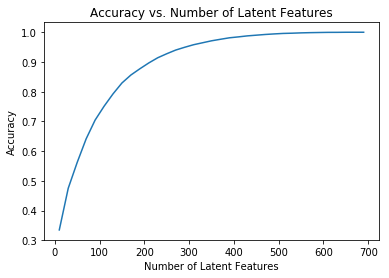

In [59]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [60]:
df_train = clean_df.head(40000)
df_test = clean_df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    """
    Description:
        Return the train and test datasets
    
    Args:
        df_train (dataframe): train dataframe
        df_test (dataframe): test dataframe

    Returns:
        user_item_train (dataframe): a user-item matrix of the training dataframe 
        user_item_test  (dataframe): a user-item matrix of the testing dataframe
        test_idx (pandas series): all of the test user ids
        test_arts (pandas series): all of the test article ids
    """

    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test.user_id.unique()
    test_arts = df_test.article_id.unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

# Use the function
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [61]:
# How many users can we make predictions for in the test set?
print(np.intersect1d(test_idx,user_item_train.index.values).shape[0])

# How many users in the test set are we not able to make predictions for because of the cold start problem?
print(test_idx.shape[0] - np.intersect1d(test_idx,user_item_train.index.values).shape[0])

# How many articles can we make predictions for in the test set?
print(np.intersect1d(test_arts, user_item_train.columns.values).shape[0])

# How many articles in the test set are we not able to make predictions for because of the cold start problem?
print(test_arts.shape[0] - np.intersect1d(test_arts, user_item_train.columns.values).shape[0])

20
662
574
0


In [62]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}


t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [63]:
# SVD should be fitted to the user item train matrix.
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd

In [64]:
# Get the values from the user item train train that correspond to the possible users.
test_rows_idx = user_item_train.index.isin(test_idx)
test_col_idx = user_item_train.columns.isin(test_arts)
u_test = u_train[test_rows_idx, :]
vt_test = vt_train[:, test_col_idx]

# s_test = s_train

# find the users who appear in both the training and test datasets
user_present_both = np.intersect1d(user_item_test.index, user_item_train.index)
user_item_test_predictable = user_item_test[user_item_test.index.isin(user_present_both)]

In [65]:
# Initialize testing parameters
num_latent_feats = np.arange(1,700+10,20)

# Errors in the train and test datasets should be recorded.
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # Both training and test sets should be restructured with k latent features.
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # Use the dot product for both training and testing.
    user_item_train_est = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_est = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # Calculate the error from each prediction to the actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_predictable, user_item_test_est)
    
    # Sum errors for both training and test sets
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

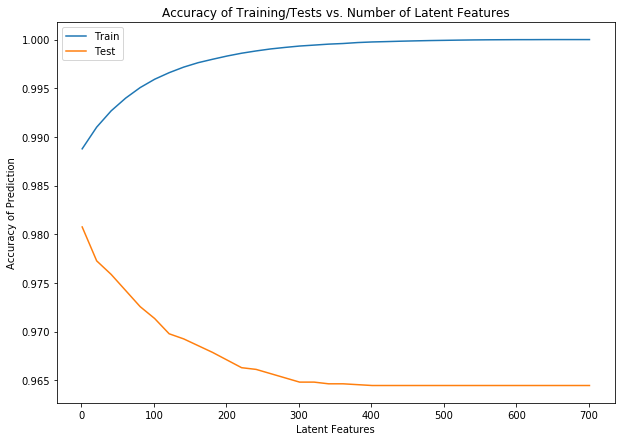

In [66]:
# Plot the graph
plt.figure(figsize=(10, 7))
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] 
                                                         * user_item_test_predictable.shape[1]), label='Train')
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test_predictable.shape[0] 
                                                        * user_item_test_predictable.shape[1]), label='Test')
plt.xlabel('Latent Features')
plt.ylabel('Accuracy of Prediction')
plt.legend()
plt.title('Accuracy of Training/Tests vs. Number of Latent Features')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Answer:**

* Because this is mostly a sparse matrix, we may not need to use many latent features to reproduce the original matrix correctly. Although the accuracy of prediction for train data increases with the number of latent features, the accuracy of prediction for test data decreases. This could be due to the imbalanced dataset. Actually, only 20 of the over 4000 users in the train set are also in the test set, and latent features that capture the relationship between users and activities in the train data set may not be useful for predicting activities in the test set.

* We could make recommendations for new users using the rank-based recommendation method, which is a very nice way to make recommendations without knowing anything about the user (definitely an improvement). Perhaps we can solicit information on content preferences and combine content-based recommendation with other methods of recommendation. We can use information from df content to define categories for each article, combine it with rank-based recommendation, and use it as a filter for user-user based collaborative filtering.

* An AB test can be used to determine whether any of the recommendation systems are superior to the original process of users discovering articles of interest. It can be implemented by dividing users into two groups, with one group being recommended using rank-based recommendation and the other group being recommended using matrix-factorization.

* An online approach to determining the usefulness of different recommendation systems is an alternative to the previously used offline method (Matrix factorization testing). For instance, we could use an A/B test to compare the effectiveness of one recommendation system to another. This will assist in determining how well the recommendation engine systems work and whether any of the recommendation systems outperform the original process of users discovering articles of interest. We would divide users into groups of an equal number of users using cookies. Group A would employ one recommendation system, whereas Group B would employ another.

### <a class="anchor" id="Content-Recs">Part VI: FunkSVD (EXTRA - PERSONAL)</a>

In [67]:
del df
df = pd.read_csv('data/user-item-interactions.csv')
del df['Unnamed: 0']

clean_df = clean_data(df)

In [68]:
# Load the matrix here

user_item = df.groupby(["user_id", "article_id"])["title"].count().unstack()

user_item_matrix = user_item

In [69]:
# quick look at the matrix
user_item_matrix.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
def FunkSVD(ratings_mat, latent_features=15, learning_rate=0.0001, iters=100):
    """
    Description:
        This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    Args:
        ratings_mat (numpy array): a matrix with users as rows and articles as columns
        latent_features (int): the number of latent features used
        learning_rate (float): the learning rate 
        iters (int): the number of iterations
    
    Returns:
        user_mat (numpy array): a user by latent feature matrix
        article_mat (numpy array): a latent feature by article matrix
    """
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_articles = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    
    # initialize the user and article matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    article_mat = np.random.rand(latent_features, n_articles)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-article pair
        for i in range(n_users):
            for j in range(n_articles):
                
                # if the rating exists
                if ratings_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and article latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], article_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*article_mat[k, j])
                        article_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
    return user_mat, article_mat 

In [71]:
# Create user-by-item matrix
train_data_np = np.array(user_item_matrix)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, article_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 2.737049
2 		 1.539997
3 		 1.318174
4 		 1.127475
5 		 0.944805
6 		 0.804539
7 		 0.703786
8 		 0.622103
9 		 0.554166
10 		 0.497666
11 		 0.450313
12 		 0.410212
13 		 0.375928
14 		 0.346385
15 		 0.320750
16 		 0.298352
17 		 0.278643
18 		 0.261174
19 		 0.245582
20 		 0.231574
21 		 0.218917
22 		 0.207426
23 		 0.196951
24 		 0.187372
25 		 0.178588
26 		 0.170513
27 		 0.163076
28 		 0.156211
29 		 0.149864
30 		 0.143983
31 		 0.138524
32 		 0.133447
33 		 0.128715
34 		 0.124298
35 		 0.120167
36 		 0.116295
37 		 0.112661
38 		 0.109242
39 		 0.106022
40 		 0.102984
41 		 0.100113
42 		 0.097396
43 		 0.094820
44 		 0.092376
45 		 0.090053
46 		 0.087844
47 		 0.085739
48 		 0.083731
49 		 0.081815
50 		 0.079984
51 		 0.078233
52 		 0.076556
53 		 0.074950
54 		 0.073409
55 		 0.071930
56 		 0.070509
57 		 0.069143
58 		 0.067829
59 		 0.066564
60 		 0.065345
61 		 0.064170
62 		 0.063036
63 		 0.061941
64 		 0

In [72]:
def predict_rating(user_matrix, article_matrix, user_id, article_id, train_data_df):
    """
    Description:
        This function perfom the prediction
    
    Args:
        user_matrix (dataframe): user by latent factor matrix
        article_matrix (dataframe): latent factor by article matrix
        user_id (int): the user_id from the reviews df
        article_id (int): the article_id according the articles df
    
    Returns:
        pred (float): the predicted rating for user_id-article_id according to FunkSVD
    """
    
    # Use the training data to create a series of users and articles that matches the ordering in training data
    user_ids_series = np.array(train_data_df.index)
    article_ids_series = np.array(train_data_df.columns)
    
    # User row and article Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    article_col = np.where(article_ids_series == article_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], article_matrix[:, article_col])
    
    return round(pred)

In [73]:
# Test your function with the first user-movie in the user-article matrix (notice this is a nan)
pred_val = predict_rating(user_mat, article_mat, 2, 20, user_item_matrix)
pred_val

1.0

In [74]:
user_item_matrix.loc[2, 20]

nan

In [75]:
# A rating of 1 indicates interest, while a rating of 0 indicates that the user is not interested.

def print_prediction_summary(user_id, article_id, prediction):
    """
    Description:
        This function print the prediction in a nice way
    
    Args:
        user_id (int): the user_id from the reviews df
        article_id (int): the article_id according the articles df
        prediction (float): the predicted rating for user_id-article_id
    
    """
    
    aux_df = df.drop_duplicates(subset=['article_id'])
    article_name = str(aux_df[aux_df['article_id'] == article_id]['title'].values[0])
    print("For user {} we predict a {} rating for the article - '{}'.".format(user_id, round(prediction, 2), article_name))

In [76]:
# Test your function the the results of the previous function
print_prediction_summary(2, 15, predict_rating(user_mat, article_mat, 2, 15, user_item_matrix))

For user 2 we predict a 1.0 rating for the article - 'apache spark™ 2.0: extend structured streaming for spark ml'.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!

In [78]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0